In [42]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
import sys
sys.path.append("C:/Users/maher/Unsupervised-anomaly-detection-on-noisy-time-series-data-for-accurate-load-forecasting/src")

from utils.utils import set_seed
set_seed(0)

# Load & clean data

In [44]:
csv_path = "../../dataset/raw/INPG/predis-mhi.csv"
feature_name = "conso_global"
window_size = 24
step = 24 # stride

In [45]:
df = pd.read_csv(csv_path, sep=";")
df['date_time'] = pd.to_datetime(df['date_time'], format="%m/%d/%Y %H:%M:%S")
load = df.set_index('date_time')
load.head()

,conso_global
date_time,
2016-01-01 00:00:00,0.0
2016-01-01 01:00:00,0.0
2016-01-01 02:00:00,1.0
2016-01-01 03:00:00,1.0
2016-01-01 04:00:00,0.0


In [46]:
# remove duplicate indices

load = load[~load.index.duplicated()]

In [47]:
# replace missing values by the value of the previous week

idx = pd.date_range(load.index[0], load.index[-1], freq="H")
load = load.reindex(idx, fill_value=np.nan)
load = load.fillna(load.shift(window_size*7))

In [48]:
# replace outliers by the value of the previous week

outliers = load[load[feature_name] > 2*load[feature_name].quantile(0.99)]
for i in range(len(outliers)):
    load.loc[outliers.index[i], feature_name] = load.loc[outliers.index[i] - pd.Timedelta(weeks=1), feature_name]

In [49]:
# removing national holidays and weekends

import holidays
from datetime import datetime, timedelta

fr_holidays = holidays.France(years=list(range(2016, 2023)))
holiday_dates = list(fr_holidays.keys())

# holiday_dates: 2016-01-01 -> 2016-01-01 00:00:00 with 1h step
sampled_dates = []
for date in holiday_dates:
    start_time = datetime(date.year, date.month, date.day, 0, 0, 0) # Start at 00:00:00
    sampled_dates.append(start_time)
    for _ in range(23):
        start_time += timedelta(hours=1)
        sampled_dates.append(start_time)

full_Holiday_date = [str(date) for date in sampled_dates]

load = load[~load.index.dayofweek.isin([5, 6]) & ~load.index.isin(list(full_Holiday_date))]


In [50]:
# remove lab holidays

lab_holidays = []
for year in range(2016, 2023):
    lab_holidays.extend(pd.date_range(f'{year}-07-31', f'{year}-08-16', freq='H')[:-1]) # summer holidays
    lab_holidays.extend(pd.date_range(f'{year}-12-21', f'{year+1}-01-04', freq='H')[:-1]) # christmas holidays
load = load[~load.index.isin(list(lab_holidays))]


In [51]:
# remove covid period

covid_dates = []
covid_dates.extend(pd.date_range('2020-03-17', '2020-06-12', freq='H')[:-1]) # ok

load = load[~load.index.isin(list(covid_dates))] # this is not working, make it work

In [52]:
# remove corrupt data

dates_to_remove = []
# date range
dates_to_remove.extend(pd.date_range('2016-06-21', '2016-11-11', freq="H")[:-1])
dates_to_remove.extend(pd.date_range('2017-08-16', '2017-08-21', freq="H")[:-1])
dates_to_remove.extend(pd.date_range('2019-07-29', '2019-08-23', freq="H")[:-1])
dates_to_remove.extend(pd.date_range('2020-09-21', '2020-10-08', freq="H")[:-1])
dates_to_remove.extend(pd.date_range('2021-05-14', '2021-05-17', freq="H")[:-1])
# 1 day
dates_to_remove.extend(pd.date_range('2019-05-31', '2019-06-01', freq="H")[:-1])
dates_to_remove.extend(pd.date_range('2019-08-23', '2019-08-24', freq="H")[:-1])
dates_to_remove.extend(pd.date_range('2022-05-27', '2022-05-28', freq="H")[:-1])

load = load[~load.index.isin(dates_to_remove)]

In [53]:
# remove uncomplete last day
load = load[load.index < f"{str(load.index[-1])[:10]} 00:00:00"]

In [54]:
# # save plots to manually find days with problems

# path = "../../results/data_display"
# os.makedirs(path, exist_ok=True)

# n_days = 3
# day_size = 24

# def get_feature(day0):
#     sequence = []
#     start = day0
#     end = start + window_size
#     for day in range(n_days):
#         sequence.extend(load[feature_name].values[start: end])
#         start += day_size#*7
#         end += day_size#*7
#     return sequence

# data = []
# for i in range(len(load)//day_size - n_days*day_size):    
#     day0 = i*day_size
#     sequence = get_feature(day0)
#     data.append(sequence)

# for i in range(len(data)-4):
#     day0 = i*day_size
#     sequence = get_feature(day0)

#     plt.plot(sequence)
#     plt.savefig(f"{path}/{load.index[day0]} -- {load.index[day0 + day_size*n_days]}.png".replace(":", "-"))
#     plt.clf()


# Synthesizing realistic power anomalies

credits:

code from: https://github.com/KIT-IAI/pyWATTS/blob/master/pywatts/modules/generation/power_anomaly_generation_module.py

citation: Modeling and Generating Synthetic Anomalies for Energy and Power Time Series, Marian Turowski

2019-04-24 00:00:00 ->  2019-04-24 23:00:00


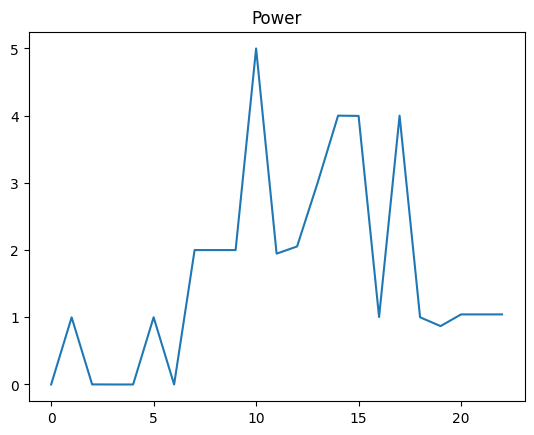

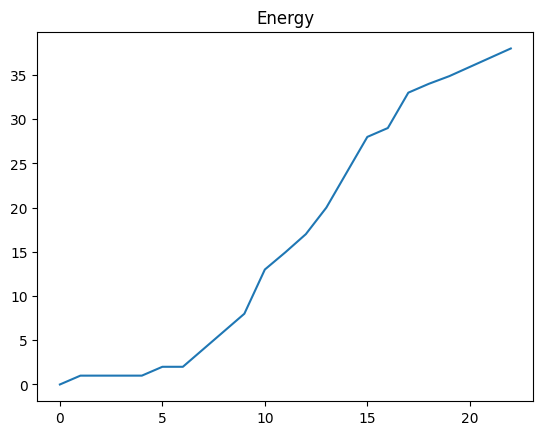

In [55]:
r = np.random.randint(0, len(load)//24-1)
print(load.index[window_size*r], "-> ", load.index[window_size*(r+1)-1])

power = np.array(load.values[window_size*r: window_size*(r+1)-1])
energy = np.cumsum(power)

plt.plot(power)
plt.title("Power")
plt.show()

plt.plot(energy)
plt.title("Energy")
plt.show()

In [56]:
def _anomaly_type1(target, indices, lengths, k=0):
    """
    Anomaly type 1 that drops the power time series values to a negative value potentially followed by zero values
    before adding the missed sum of power to the end of the anomaly.
    """
    for idx, length in zip(indices, lengths):
        if length <= 2:
            raise Exception("Type 1 power anomalies must be longer than 2.")
        else:
            # WARNING: This could lead to a overflow quite fast?
            energy_at_start = target[:idx].sum() + k
            energy_at_end = target[:idx + length].sum() + k
            target[idx] = -1 * energy_at_start          # replace first by negative peak
            target[idx + 1:idx + length - 1] = 0        # set other values to zero
            target[idx + length - 1] = energy_at_end    # replace last with sum of missing values + k
    return target

def _anomaly_type2(target, indices, lengths, softstart=True):
    """
    Anomaly type 2 that drops the power time series values to potentially zero and adds the missed sum of power to
    the end of the anomaly.
    """
    for idx, length in zip(indices, lengths):
        if length <= 1:
            raise Exception("Type 2 power anomalies must be longer than 1.")
        else:
            if softstart:
                r = np.random.rand()
                energy_consumed = target[idx:idx + length].sum()
                target[idx] = r * target[idx]
                target[idx + 1:idx + length - 1] = 0
                target[idx + length - 1] = energy_consumed - target[idx]
            else:
                energy_consumed = target[idx:idx + length].sum()
                target[idx:idx + length - 1] = 0
                target[idx + length - 1] = energy_consumed
    return target

def _anomaly_type3(target, indices, lengths,
                    is_extreme=False, range_r=(0.01, 3.99), k=0):
    """
    Anomaly type 3 that creates a negatives peak in the power time series.
    """
    for idx, length in zip(indices, lengths):
        if length > 1:
            raise Exception("Type 3 power anomalies can't be longer than 1.")
        else:
            if is_extreme:
                energy_consumed = target[:idx].sum()
                target[idx] = -1 * energy_consumed - k
            else:
                r = np.random.uniform(*range_r)
                target[idx] = -1 * r * target[idx - 1]
    return target

def _anomaly_type4(target, indices, lengths,
                   is_extreme=False, range_r=(0.01, 3.99), k=0):
    """
    Anomaly type 4 that creates a positive peak in the power time series.
    """
    for idx, length in zip(indices, lengths):
        if length > 1:
            raise Exception("Type 4 power anomalies can't be longer than 1.")
        else:
            if is_extreme:
                energy_consumed = target[:idx].sum()
                target[idx] = energy_consumed - k
            else:
                r = np.random.uniform(*range_r)
                target[idx] = r * target[idx - 1]
    return target


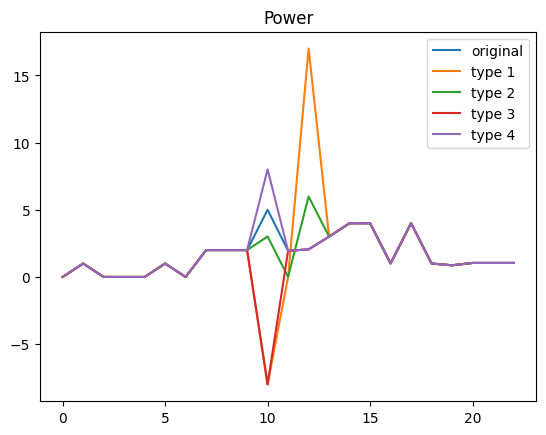

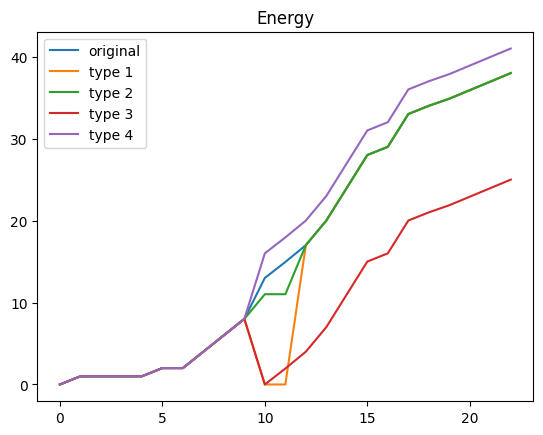

In [57]:
position = np.random.randint(len(power)//4, (len(power)-1)//5*4)
length = np.random.randint(3, len(power)-1-position)

anomalous_power_type_1 = _anomaly_type1(power.copy(), [position], [length])
anomalous_power_type_2 = _anomaly_type2(power.copy(), [position], [length])
anomalous_power_type_3 = _anomaly_type3(power.copy(), [position], [1], is_extreme=True)
anomalous_power_type_4 = _anomaly_type4(power.copy(), [position], [1], is_extreme=True)

plt.plot(power, label="original")
plt.plot(anomalous_power_type_1, label="type 1")
plt.plot(anomalous_power_type_2, label="type 2")
plt.plot(anomalous_power_type_3, label="type 3")
plt.plot(anomalous_power_type_4, label="type 4")
plt.title("Power")
plt.legend()
plt.show()

energy = np.cumsum(power)
anomalous_energy_1 = np.cumsum(anomalous_power_type_1)
anomalous_energy_2 = np.cumsum(anomalous_power_type_2)
anomalous_energy_3 = np.cumsum(anomalous_power_type_3)
anomalous_energy_4 = np.cumsum(anomalous_power_type_4)
plt.plot(energy, label="original")
plt.plot(anomalous_energy_1, label="type 1")
plt.plot(anomalous_energy_2, label="type 2")
plt.plot(anomalous_energy_3, label="type 3")
plt.plot(anomalous_energy_4, label="type 4")
plt.title("Energy")
plt.legend()
plt.show()

# Contaminating & saving data

In [58]:
def inject_anomaly(sequence, anom_type=0, n_anom=1, minimum_length=10):
    sequence = sequence.copy()
    n = len(sequence)
    # TODO add handling multiple number of anomalies

    if anom_type==0:
        anom_type = np.random.randint(1, 4)

    if anom_type==1:
        position = np.random.randint(n//4, (len(sequence)-1)//2)
        remaining_length = len(sequence)-1-position
        length = np.random.randint(max(3, (remaining_length//3*2)), remaining_length)
        return _anomaly_type1(sequence.copy(), [position], [length])
    
    if anom_type==2:
        position = np.random.randint(n//4, (len(sequence)-1)//2)
        remaining_length = len(sequence)-1-position
        length = np.random.randint(max(2, (remaining_length//3*2)), remaining_length)
        return _anomaly_type2(sequence.copy(), [position], [length])
    
    if anom_type==3:
        position = np.random.randint(n//4, (len(sequence)-1)//3*2)
        return _anomaly_type3(sequence, [position], [1])
    
    if anom_type==4:
        position = np.random.randint(n//4, (len(sequence)-1)//3*2)
        return _anomaly_type4(sequence, position, [1])


In [59]:
# parameters

contam_ratio = 0.2          # real day contam rate is contam_ratio/n_days as we add a single anomaly per day, /=day_size to get point contam rate
contam_clean_ratio = 0.85   # we save clean data to later evaluate the forecasting model on
ad_split_ratio = 0.6        # contam data is split into train and test sets for the anomaly detection model
trg_save_data = "../../dataset/processed/INPG/"
n_days = 3
day_size = 24

In [60]:
# split contam data into train and test sets for anomaly detection model

N = int(contam_clean_ratio*len(load))//day_size*day_size
M = int(ad_split_ratio*(len(load[:N])))//day_size*day_size

contaminated_load = load[:N]
clean_load = load[N:]

ad_train_load = contaminated_load[:M]
ad_test_load = contaminated_load[M:]

In [62]:
def contam_load(load, contam_ratio, feature_name, day_size):
    gt = []
    n_clean_days = int((1-contam_ratio)*len(load)//day_size)
    for i in range(len(load)//day_size):
        # contamination ratio is one every n_days, after n_clean_days
        contam = i>=n_clean_days and i%n_days==0 
        #TODO check stride effect, no_strid -> anom always same day, stride -> dataset size difference after filtering is bigger
        if contam:
            day_st = i*day_size
            day_end = day_st + day_size
            sequence = load[feature_name].values[day_st: day_end]
            load[feature_name].values[day_st: day_end] = inject_anomaly(sequence)
            gt.extend([1]*day_size)
        else:
            gt.extend([0]*day_size)
    return load, gt

def extract_consec_days(load, gt_load, day0, n_days, day_size):
    """return n_days consecutive days starting at day0 from load dataframe"""

    sequence, gt = [], []
    start = day0
    end = start + window_size

    for day in range(n_days): # stride = 1day
        sequence.extend(load[feature_name].values[start: end])
        gt.extend(gt_load[start: end])
        start += day_size
        end += day_size
    return np.array(sequence), np.array(gt)

def build_dataset(load, n_days, day_size, contam_ratio, contam_data=True):
    """
        build a dataset from load dataframe using a sliding window of size n_days and stride of 1 day 
        while contamining the data with synthetic anomalies
    """
    if contam_data:
        load, gt_load = contam_load(load, contam_ratio, feature_name, day_size)
    else:
        gt_load = [[0]*day_size]*(len(load)//day_size)
    
    time_wind = []
    gt_time_wind = []

    for i in range(len(load)//day_size - n_days):
        day0 = i*day_size
        sequence, gt = extract_consec_days(load, gt_load, day0, n_days, day_size)

        time_wind.append(sequence)
        gt_time_wind.append(gt)

    return time_wind, gt_time_wind


ad_train_windows, gt_ad_train_windows = build_dataset(ad_train_load, n_days, day_size, contam_ratio)
ad_test_windows, gt_ad_test_windows = build_dataset(ad_test_load, n_days, day_size, contam_ratio)
clean_windows, gt_clean_windows = build_dataset(clean_load, n_days, day_size, contam_ratio, contam_data=False)

print(f"Number of clean windows: {len(clean_windows)}")
print(f"Number of ad_train_contam windows: {len(ad_train_windows)}")
print(f"Number of ad_test_contam windows: {len(ad_test_windows)}")

day_contam_ratio = contam_ratio*1/n_days
datapoint_contam_ratio = 1/day_size*day_contam_ratio

print(f"\n{day_contam_ratio*100:.2f}% of days are contaminated.")
print(f"0{datapoint_contam_ratio*100:.2f}% of datapoints are contaminated.")

Number of clean windows: 208
Number of ad_train_contam windows: 713
Number of ad_test_contam windows: 475

6.67% of days are contaminated.
00.28% of datapoints are contaminated.


## Normalize windows

for AEMO, data is aggregated load (min value is thousands of KW) -> will provoke exploding gradients.

Therefore we will normalize data with 0.01 and 99.9 quantiles. This approach can help handle outliers effectively while preserving the original units. 

To calculate MSE and MAE in the original scale after this type of normalization:

MSE_original_scale = MSE_normalized * (X_99.9 - X_0.01)^2

MAE_original_scale = MAE_normalized * (X_99.9 - X_0.01)

(this is not needed for the INPG dataset (single building load), can do it anyway)

In [63]:
min_quantile = 0.01
max_quantile = 0.99

min_q_val = clean_load.quantile(min_quantile).item()
max_q_val = clean_load.quantile(max_quantile).item()

print(f"min_quantile={min_quantile:0.3f} -> value={min_q_val}")
print(f"max_quantile={max_quantile:0.3f} -> value={max_q_val}")


min_quantile=0.010 -> value=0.0
max_quantile=0.990 -> value=16.00056986390216


In [64]:
def scale_windows(windows_list, min_q_val, max_q_val):
    scaled_windows = []
    for window in windows_list:
        window = (window - min_q_val) / (max_q_val - min_q_val)
        scaled_windows.append(window)
    return scaled_windows

clean_windows = scale_windows(clean_windows, min_q_val, max_q_val)
ad_train_windows = scale_windows(ad_train_windows, min_q_val, max_q_val)
ad_test_windows = scale_windows(ad_test_windows, min_q_val, max_q_val)

In [ ]:
## Save data

In [65]:
# remove existing files in save target root folder
existing_files = glob.glob(os.path.join(trg_save_data, "*", "*", "*.npy"))
for f in existing_files:
    os.remove(f)
# crete save target folders if they don't exist
os.makedirs(os.path.join(trg_save_data, "lf_test_clean", "data"), exist_ok=True)
os.makedirs(os.path.join(trg_save_data, "ad_train_contam", "data"), exist_ok=True)
os.makedirs(os.path.join(trg_save_data, "ad_train_contam", "gt"), exist_ok=True)
os.makedirs(os.path.join(trg_save_data, "ad_test_contam", "data"), exist_ok=True)
os.makedirs(os.path.join(trg_save_data, "ad_test_contam", "gt"), exist_ok=True)

# save clean lf data
for i, sample in enumerate(clean_windows):
    if np.isnan(sample).any(): continue
    np.save(os.path.join(trg_save_data, "lf_test_clean", "data", str(i)), sample)

# save contam ad train data
for i, (sample, sample_gt) in enumerate(zip(ad_train_windows, gt_ad_train_windows)):
    if np.isnan(sample).any(): continue
    np.save(os.path.join(trg_save_data, "ad_train_contam", "data", str(i)), sample)
    np.save(os.path.join(trg_save_data, "ad_train_contam", "gt", str(i)), sample_gt)

# save contam ad test data
for i, (sample, sample_gt) in enumerate(zip(ad_test_windows, gt_ad_test_windows)):
    if np.isnan(sample).any(): continue
    np.save(os.path.join(trg_save_data, "ad_test_contam", "data", str(i)), sample)
    np.save(os.path.join(trg_save_data, "ad_test_contam", "gt", str(i)), sample_gt)


In [23]:
# path = "../../results/data_display"
# os.makedirs(path, exist_ok=True)

# for j, (sample, sample_gt) in enumerate(zip(ad_test_windows, gt_ad_test_windows)):
#     plt.plot(sample)
#     plt.title(f"gt: {sample_gt.count(1)/len(sample_gt)>0}")
#     plt.savefig(f"../../results/data_display/{j}.png")
#     plt.clf()

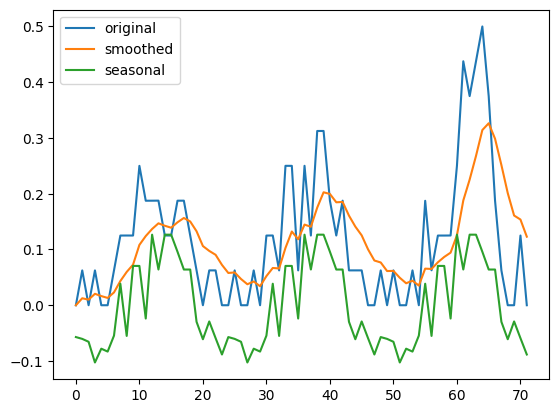

<Figure size 640x480 with 0 Axes>

In [69]:
for i in range(len(ad_test_windows)):
        time_series = ad_test_windows[i]
        # if time_series.max()-time_series.min() < 20: continue
        if i > 0: break

        window_size=3
        plt.plot(time_series, label="original")


        alpha = 0.2
        smoothed_values = [0]
        for i in range(1, len(time_series)):
                smoothed_value = alpha * time_series[i] + (1 - alpha) * smoothed_values[-1]
                smoothed_values.append(smoothed_value)
        plt.plot(smoothed_values, label="smoothed")


        # Seasonal decomposition using statsmodels
        import torch
        import statsmodels.api as sm
        seasonal_period = 24
        decomposition = sm.tsa.seasonal_decompose(time_series, period=seasonal_period)
        seasonal_component = torch.tensor(decomposition.seasonal, dtype=torch.float32).unsqueeze(1)
        trend_component = torch.tensor(decomposition.trend, dtype=torch.float32).unsqueeze(1)
        residual_component = torch.tensor(decomposition.resid, dtype=torch.float32).unsqueeze(1)
        plt.plot(seasonal_component, label="seasonal")
        plt.legend()
        plt.show()
        plt.clf()